transforms a shapefile with admnistrative boundaries to SVG conserving attributes

In [58]:
import matplotlib.pylab as plt
import geopandas as gpd
import fiona
%matplotlib inline


In [60]:
shp=gpd.read_file("PHL_adm1.shp")



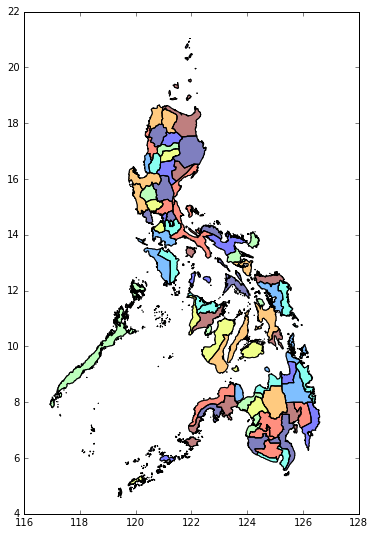

In [61]:
plt.figure(figsize=(9,9))
shp.plot()

KeyError: 'data-class'

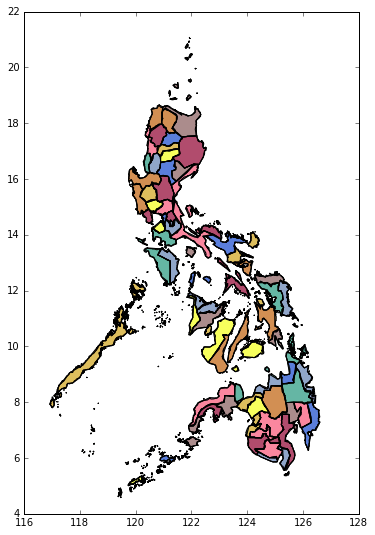

In [67]:
#Simplify
simple =shp.simplify(0.05)
plt.figure(figsize=(9,9))
shp.plot()
simple.plot()
test.to_file("PHL_adm1_simple.shp")
shp_to_svg(my_shapefile_path = "PHL_adm1_simple.shp", target_svg = 'BlankSimpleMap.svg')

KeyError: 'data-class'

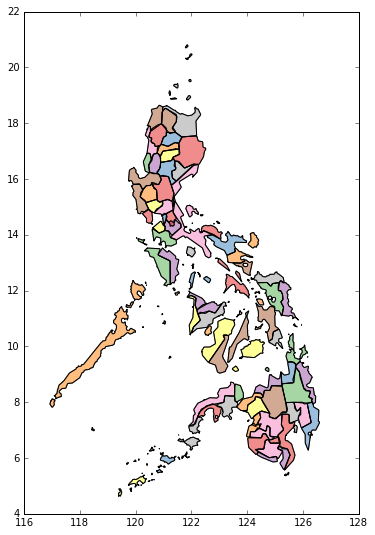

In [64]:
#remove small shapes    http://gis.stackexchange.com/questions/120286/removing-small-polygons-gaps-in-a-shapely-polygon

eps = 0.05  # epsilon that is approx. the width of slivers

test=simple.buffer(eps, 1).buffer(-eps)

plt.figure(figsize=(9,9))
test.plot()
test.to_file("PHL_adm1_simple_droped.shp")
shp_to_svg(my_shapefile_path = "PHL_adm1_simple_droped.shp", target_svg = 'BlankSimpleMapDroped.svg')

In [ ]:
#remove small shapes    http://gis.stackexchange.com/questions/120286/removing-small-polygons-gaps-in-a-shapely-polygon

eps = 0.05  # epsilon that is approx. the width of slivers

test=simple.buffer(eps, 1).buffer(-eps)

plt.figure(figsize=(9,9))
test.plot()
test.to_file("PHL_adm1_simple_droped.shp")
shp_to_svg(my_shapefile_path = "PHL_adm1_simple_droped.shp", target_svg = 'BlankSimpleMapDroped.svg')

In [49]:
#trying a method where I manually remove small-area polygons  (not finished)
min_area = shp.area.min()/10

series  = shp.ix[5]
for s in series.geometry:
    list_of_series =[]
    if (s.area) > min_area:
        

## Kartograph

In [50]:
from string import Template
from subprocess import call
import os
from bs4 import BeautifulSoup



In [72]:
def shp_to_svg(my_shapefile_path = "PHL_adm1.shp", my_reg_id = "NAME_1", 
               target_svg = 'BlankSimpleMap.svg', my_svg_title = "Map of the Philippines",
               k_config_model = 'kartograph_config_model.json'):

    #Temp file names
    file, ext = os.path.splitext(target_svg)
    tmp_svg_file = file+"_raw"+ext
    tmp_config_file = "katograph_config_tmp.json"

    #get generic Kartograph configuration
    with open(k_config_model, 'r') as myfile:
        katograph_config_model=myfile.read()

    #specifies K config with user paramters   
    katograph_config = Template(katograph_config_model).safe_substitute(
        shapefile_path=my_shapefile_path, region_identifier=my_reg_id) #use Template to format a string that contains extra curly brackets
    #writes the config file 
    with open(tmp_config_file, "w") as text_file:
        text_file.write(katograph_config)

    #calls Kartograph 
    err= call("activate py2 & kartograph "+tmp_config_file+" -o "+tmp_svg_file, shell=True)
    if err>0:
        print("error " + err)
        return

    ### POST-PROCESSES THE KARTOGRAPH SVG: DATA-CLASS TO CLASS AND PRETTY INDENTATION

    #opens 
    with open(tmp_svg_file, 'r', encoding='utf8') as svgfile:
        thesvg = svgfile.read()

    #parses the SVG (an XML file)
    soup=BeautifulSoup(thesvg,"xml")

    #renames all the "data-class" from Kartograph to "class" and gives them a title (for mouse hover)
    for path in soup.findAll("path"):
        path["class"]=path["data-class"]
        del path["data-class"]
        p_title = soup.new_tag("title")
        p_title.string = path["class"]
        path.insert(1,p_title)

    #gives a class to the big shape (wont work if there are oceans as they will get default format)    
    for g in soup.findAll("g"):
        g["class"]  = g["id"]    

    #Add a title to the whole SVG    
    new_title =soup.new_tag("title")
    new_title.string= my_svg_title
    soup.svg.insert(1,new_title)

    #deletes "pretty print" and enable_background attirbutes (unimportant)
    del soup.svg["pretty_print"]
    del soup.svg["enable_background"]

    #OVERWRITES the initial SVG with the new SVG    
    with open(target_svg, 'w',  encoding='utf8') as svgfile:
        svgfile.write(soup.prettify())


    #deletes temp files

    #Kartograph config
    if os.path.exists(tmp_config_file):
        try:
            os.remove(tmp_config_file)
        except:
            pass

    #Unformated SVG    
    if os.path.exists(tmp_svg_file):
        try:
            os.remove(tmp_svg_file)   
        except:
            pass

In [75]:
shp_to_svg()

In [74]:
shp=gpd.read_file("PHL_adm1.shp")
shp.to_file("PHL_dumbtest.shp")
shp_to_svg(my_shapefile_path = "PHL_dumbtest.shp", target_svg = 'dumbtest.svg')

In [76]:
shp_to_svg(my_shapefile_path = "PHL_adm1_mapshaper.shp", target_svg = 'PHL_adm1_mapshaper.svg')